In [29]:
import os
import pandas as pd
import glob
import nilearn
from nilearn.glm.first_level import FirstLevelModel
import json
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.plotting import plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
import numpy as np
from scipy.stats import norm
from nilearn.image import math_img
from nilearn.image import threshold_img
from nilearn.glm import threshold_stats_img


In [2]:
#get confounds for any subject and task


def get_confounds(sub,task,ses,run):

    #might need to be adjusted once the dataset is fully BIDS-compliant!
    all_confounds = pd.read_csv(f"../../derivatives/fmriprep-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_rec-moco_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')

    
    motion_params = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z']
    # motion_trans_params = [col for col in all_confounds.columns if 'trans' in col] #change to these if desired
    # motion_rot_params = [col for col in all_confounds.columns if 'rot' in col] #change to these if desired
    # motion_params=motion_trans_params+motion_rot_params #change to these if desired

    motion_outliers = [col for col in all_confounds.columns if 'motion' in col]
    cosine_regressors = [col for col in all_confounds.columns if 'cosine' in col]

    #these can be adjusted to be from the combined wm csf, for example
    num_a_comp_cors=50
    a_comp_cors = []
    for i in range(num_a_comp_cors):
        a_comp_cors.append('a_comp_cor_{:02d}'.format(i))
        
    selected_confounds = all_confounds[['csf','framewise_displacement']+motion_params+motion_outliers+cosine_regressors+a_comp_cors].copy()

    for col in selected_confounds.columns:
        if 'derivative' or 'framewise_displacement' in col:
            if pd.isna(selected_confounds[col][0]):
                selected_confounds[col][0]=0
    
    return selected_confounds



In [3]:
#glm model


def run_first_level_model(sub,task,ses):
    memory = '../../../nilearn_cache' #change if desired
    space='MNI152NLin6Asym' #change if desired

    nifti_locations = (glob.glob(f'../../derivatives/fmriprep-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-moco*run-*{space}*preproc*nii.gz'))
    events_locations = (glob.glob(f"../../sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-moco*run-*events.tsv"))
    mask_locations = (glob.glob(f'../../derivatives/fmriprep-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-moco*run-*{space}*brain_mask.nii.gz'))


    niftis=nifti_locations[0:2]
    events=events_locations[0:2]
    mask=mask_locations[0] #this assumes brain mask is the same for all
    
    selected_confounds=[get_confounds(sub,task,ses,1)]
    if len(nifti_locations)>1:
        selected_confounds=selected_confounds+[get_confounds(sub,task,ses,2)]

# this IS subject specific due to mask!!  mask_img=mask,
    glm = FirstLevelModel(t_r = 1.53, mask_img=mask, \
        slice_time_ref=0.5, smoothing_fwhm=6.0, hrf_model='glover', drift_model=None, \
        high_pass=None, drift_order=4, standardize=False, signal_scaling=False, noise_model='ar1', \
        memory=memory, minimize_memory=False, verbose=0, n_jobs=-2)

    glm = glm.fit(niftis, events=events, confounds=selected_confounds)
    
    return glm


In [4]:
#plot design matrix for one subject

def show_design_matrix(fitted_glm):
    design_matrix = fitted_glm.design_matrices_[0]
    plot_design_matrix(design_matrix)
    plt.show()

In [5]:
def make_localizer_contrasts(design_matrix,task):
    """ returns a dictionary of contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    
    # Short dictionary of more relevant contrasts
    if task == 'nback':
        contrasts = {'two - zero': (contrasts['twoback'] - contrasts['zeroback'])}
    
    return contrasts

In [6]:
def plot_contrast(glm,task):
    """ Given a first model, specify, estimate and plot the main contrasts"""
    # Call the contrast specification within the function
    design_matrix = glm.design_matrices_[0]
    contrasts = make_localizer_contrasts(design_matrix,task)
    fig = plt.figure(figsize=(11, 3))
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        ax = plt.subplot(1, len(contrasts), 1 + index)
        z_map = glm.compute_contrast(contrast_val, output_type='z_score')
        plotting.plot_stat_map(z_map, display_mode='z', threshold=3.0, title=contrast_id, axes=ax,\
                              cut_coords=(0,12,20,28,36,44,52),)

In [7]:
# #example with one subject and one task
# fitted_glm = run_first_level_model(sub='MM100',task='nback',ses='1year')
# #show_design_matrix(fitted_glm)
# plot_contrast(fitted_glm,'nback')

In [8]:
# #example with one subject and one task to better understand output of fitted_glm.compute_contrast

# design_matrix = fitted_glm.design_matrices_[0]
# contrasts = make_localizer_contrasts(design_matrix,'nback')

# #out is a dict with the keys: z_score, stat, p_value, effect_size, effect_variance
# out = fitted_glm.compute_contrast(
#             contrasts['two - zero'], output_type='all')

# plotting.plot_stat_map(out['z_score'],cut_coords=(0,12,20,28,36,44,52),display_mode='z', threshold=3.0,vmax=9)

In [9]:
# #example with one subject and one task
# fitted_glm = run_first_level_model(sub='MM254',task='nback',ses='baseline')
# show_design_matrix(fitted_glm)
# plot_contrast(fitted_glm,'nback')

In [165]:
#loop over all subjects for Nback task to plot them

subs_baseline = [el.split('/sub-')[-1] for el in (glob.glob("/rdma/vast-rdma/scratch/Sat/dclb/mct/derivatives/freesurfer-baseline/sub-MM*"))]
subs_1year = [el.split('/sub-')[-1] for el in (glob.glob("/rdma/vast-rdma/scratch/Sat/dclb/mct/derivatives/freesurfer-1year/sub-*"))]
subs = list(set(subs_1year).intersection(set(subs_baseline)))
subs.remove('MM334') #remove subj with no events files
subs.remove('MM100') #remove subj with no baseline nback scans
subs.remove('MM122') #remove subj with no baseline nback scans
subs.remove('MM286') #need to deal with the subj with 2 runs for nback
subs = subs[:] 
task = 'nback'
sessions = ['baseline','1year']
cmaps = [[],[]]

already_done = [el.split('/sub-')[-1] for el in (glob.glob("/om2/scratch/Sat/dclb/mct/derivatives/nilearn/first_level/*_ses-baseline_task-nback_rec-moco_z_score.nii.gz"))]
already_done = [el.split('_')[0] for el in already_done]

for sub in already_done:
    subs.remove(sub)
    
for sub in subs:
    for i in range(len(sessions)):
        ses = sessions[i]
        print(sub)
        print(ses)
        
        fitted_glm = run_first_level_model(sub,task,ses)
        design_matrix = fitted_glm.design_matrices_[0]
        contrasts = make_localizer_contrasts(design_matrix,'nback')
        out = fitted_glm.compute_contrast(contrasts['two - zero'], output_type='all')
        cmaps[i].append(out['effect_size'])
        out['effect_size'].to_filename(f'../../derivatives/nilearn/first_level/sub-{sub}_ses-{ses}_task-{task}_rec-moco_effect_size.nii.gz')
        out['effect_variance'].to_filename(f'../../derivatives/nilearn/first_level/sub-{sub}_ses-{ses}_task-{task}_rec-moco_effect_variance.nii.gz')
        out['z_score'].to_filename(f'../../derivatives/nilearn/first_level/sub-{sub}_ses-{ses}_task-{task}_rec-moco_z_score.nii.gz')
        out['stat'].to_filename(f'../../derivatives/nilearn/first_level/sub-{sub}_ses-{ses}_task-{task}_rec-moco_stat.nii.gz')
        out['p_value'].to_filename(f'../../derivatives/nilearn/first_level/sub-{sub}_ses-{ses}_task-{task}_rec-moco_p_value.nii.gz')


MM249
baseline
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x2b3872c2c2e0>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x2b3872c2ccd0>, <nibabel.nifti1.Nifti1Image object at 0x2b3872c2c2e0>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': 6.0,
  'standardize': False,
  'standardize_confounds': True,
  't_r': 1.53,
  'target_affine': None,
  'target_shape': None}, memory_level=1, memory=Memory(location=../../../ni

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 34.7s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[179.18453 , ..., 190.601123],
       ...,
       [195.848658, ..., 192.908924]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.34s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 29.3s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-4.823617, ..., -4.455515]), <nibabel.nifti1.Nifti1Image object at 0x2b3872c2c2e0>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-4.965165, ..., -4.567477]), <nibabel.nifti1.Nifti1Image object at 0x2b3872c2c2e0>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.999999, ..., 0.999996]), <nibabel.nifti1.Nifti1Image object at 0x2b3872c2c2e0>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 5.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 35.2s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 39.963345, ..., 183.61599 ],
       ...,
       [ 43.919123, ..., 179.348631]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 34.3s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-2.003351, ..., -1.152831]), <nibabel.nifti1.Nifti1Image object at 0x2b38722a4880>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-2.015673, ..., -1.156115]), <nibabel.nifti1.Nifti1Image object at 0x2b38722a4880>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.97743, ..., 0.87551]), <nibabel.nifti1.Nifti1Image object at 0x2b38722a4880>)
___________________________________________________________unmask - 0.5s, 0.0min
______________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 35.2s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[115.848795, ..., 128.528375],
       ...,
       [116.486993, ..., 130.013264]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 34.5s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-2.302442, ..., -1.276136]), <nibabel.nifti1.Nifti1Image object at 0x2b3872aedd60>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-2.319839, ..., -1.280142]), <nibabel.nifti1.Nifti1Image object at 0x2b3872aedd60>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.989345, ..., 0.899046]), <nibabel.nifti1.Nifti1Image object at 0x2b3872aedd60>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 34.6s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 98.659974, ..., 103.648342],
       ...,
       [110.708066, ...,  98.524029]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.40s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 30.8s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.735751, ..., -0.884448]), <nibabel.nifti1.Nifti1Image object at 0x2b38782e8820>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.73713 , ..., -0.886366]), <nibabel.nifti1.Nifti1Image object at 0x2b38782e8820>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.769059, ..., 0.811773]), <nibabel.nifti1.Nifti1Image object at 0x2b38782e8820>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 35.2s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[163.796238, ..., 167.67348 ],
       ...,
       [174.077579, ..., 161.685969]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.41s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 30.8s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.412775, ...,  2.363666]), <nibabel.nifti1.Nifti1Image object at 0x2b38723ee820>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.413345, ...,  2.382163]), <nibabel.nifti1.Nifti1Image object at 0x2b38723ee820>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.660114, ..., 0.009048]), <nibabel.nifti1.Nifti1Image object at 0x2b38723ee820>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 5.47s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 34.9s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[182.12366 , ..., 196.902868],
       ...,
       [184.989951, ..., 193.115047]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 31.4s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.273   , ..., -0.328767]), <nibabel.nifti1.Nifti1Image object at 0x2b3873769d30>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.273353, ..., -0.329205]), <nibabel.nifti1.Nifti1Image object at 0x2b3873769d30>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.392426, ..., 0.628834]), <nibabel.nifti1.Nifti1Image object at 0x2b3873769d30>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 35.3s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[147.438182, ..., 156.682106],
       ...,
       [151.047666, ..., 155.419594]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 32.9s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-4.68265 , ...,  0.480748]), <nibabel.nifti1.Nifti1Image object at 0x2b387274a580>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-4.824644, ...,  0.481512]), <nibabel.nifti1.Nifti1Image object at 0x2b387274a580>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.999999, ..., 0.315348]), <nibabel.nifti1.Nifti1Image object at 0x2b387274a580>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 5.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 35.0s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[132.511129, ..., 142.873869],
       ...,
       [137.499714, ..., 146.609559]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 34.5s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-5.343945, ..., -0.431536]), <nibabel.nifti1.Nifti1Image object at 0x2b3872d3d100>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-5.549983, ..., -0.432183]), <nibabel.nifti1.Nifti1Image object at 0x2b3872d3d100>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.      , ..., 0.666961]), <nibabel.nifti1.Nifti1Image object at 0x2b3872d3d100>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 35.1s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[158.165088, ..., 150.395733],
       ...,
       [158.63213 , ..., 152.600698]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 32.9s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([2.856638, ..., 0.561333]), <nibabel.nifti1.Nifti1Image object at 0x2b3872e9cd90>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([2.887808, ..., 0.562205]), <nibabel.nifti1.Nifti1Image object at 0x2b3872e9cd90>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.002141, ..., 0.287285]), <nibabel.nifti1.Nifti1Image object at 0x2b3872e9cd90>)
___________________________________________________________unmask - 0.5s, 0.0min
________________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 35.1s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[163.522388, ..., 142.717042],
       ...,
       [159.283854, ..., 138.448016]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.38s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 33.0s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.249101, ..., -1.286966]), <nibabel.nifti1.Nifti1Image object at 0x2b3873769d90>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.253014, ..., -1.291149]), <nibabel.nifti1.Nifti1Image object at 0x2b3873769d90>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.105814, ..., 0.900947]), <nibabel.nifti1.Nifti1Image object at 0x2b3873769d90>)
___________________________________________________________unmask - 0.5s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 34.4s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[164.872601, ..., 112.434589],
       ...,
       [163.268527, ..., 112.862199]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 27.5s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.274669, ..., -0.492544]), <nibabel.nifti1.Nifti1Image object at 0x2b3872d3d580>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.27505 , ..., -0.493334]), <nibabel.nifti1.Nifti1Image object at 0x2b3872d3d580>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.608215, ..., 0.688833]), <nibabel.nifti1.Nifti1Image object at 0x2b3872d3d580>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.6s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[126.409443, ..., 129.533802],
       ...,
       [127.677879, ..., 128.333713]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.18s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 26.2s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.349167, ..., 0.672861]), <nibabel.nifti1.Nifti1Image object at 0x2b3879014970>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.353734, ..., 0.674032]), <nibabel.nifti1.Nifti1Image object at 0x2b3879014970>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.088642, ..., 0.250518]), <nibabel.nifti1.Nifti1Image object at 0x2b3879014970>)
___________________________________________________________unmask - 0.4s, 0.0min
________________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.1s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[116.861739, ..., 134.471263],
       ...,
       [120.732455, ..., 138.088324]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 26.3s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.095311, ..., -0.418216]), <nibabel.nifti1.Nifti1Image object at 0x2b389a9a2bb0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.095425, ..., -0.418796]), <nibabel.nifti1.Nifti1Image object at 0x2b389a9a2bb0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.537966, ..., 0.662105]), <nibabel.nifti1.Nifti1Image object at 0x2b389a9a2bb0>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 28.9s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[131.735707, ..., 129.894779],
       ...,
       [130.45906 , ..., 127.365831]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.3s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.885058, ..., -2.359518]), <nibabel.nifti1.Nifti1Image object at 0x2b38737694c0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.895234, ..., -2.377928]), <nibabel.nifti1.Nifti1Image object at 0x2b38737694c0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.970289, ..., 0.990851]), <nibabel.nifti1.Nifti1Image object at 0x2b38737694c0>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.5s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[120.399333, ..., 159.197853],
       ...,
       [116.475477, ..., 157.806234]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.4s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.188094, ..., 1.734008]), <nibabel.nifti1.Nifti1Image object at 0x2b38782e89d0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.191482, ..., 1.74224 ]), <nibabel.nifti1.Nifti1Image object at 0x2b38782e89d0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.117398, ..., 0.041458]), <nibabel.nifti1.Nifti1Image object at 0x2b38782e89d0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.01s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 28.9s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 36.272634, ..., 162.631612],
       ...,
       [ 36.815333, ..., 155.576083]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.8s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.12637 , ..., -2.178021]), <nibabel.nifti1.Nifti1Image object at 0x2b3873776160>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.129392, ..., -2.192871]), <nibabel.nifti1.Nifti1Image object at 0x2b3873776160>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.130004, ..., 0.985298]), <nibabel.nifti1.Nifti1Image object at 0x2b3873776160>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.2s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 28.689702, ..., 186.607239],
       ...,
       [ 26.526811, ..., 187.40611 ]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 26.3s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.106137, ..., -2.23558 ]), <nibabel.nifti1.Nifti1Image object at 0x2b3870407760>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.109073, ..., -2.251653]), <nibabel.nifti1.Nifti1Image object at 0x2b3870407760>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.134334, ..., 0.98731 ]), <nibabel.nifti1.Nifti1Image object at 0x2b3870407760>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.7s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[125.990929, ..., 127.133965],
       ...,
       [128.753927, ..., 120.673868]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.0s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.542947, ..., -0.235653]), <nibabel.nifti1.Nifti1Image object at 0x2b38797bee80>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.543777, ..., -0.235946]), <nibabel.nifti1.Nifti1Image object at 0x2b38797bee80>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.293583, ..., 0.593149]), <nibabel.nifti1.Nifti1Image object at 0x2b38797bee80>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 3.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.5s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 67.886124, ..., 204.90476 ],
       ...,
       [ 70.027162, ..., 201.76326 ]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 27.8s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.837876, ..., 1.122131]), <nibabel.nifti1.Nifti1Image object at 0x2b386eb4ab50>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.839561, ..., 1.125129]), <nibabel.nifti1.Nifti1Image object at 0x2b386eb4ab50>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.20105 , ..., 0.130903]), <nibabel.nifti1.Nifti1Image object at 0x2b386eb4ab50>)
___________________________________________________________unmask - 0.4s, 0.0min
________________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.3s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[122.278229, ..., 148.994362],
       ...,
       [125.49251 , ..., 143.885738]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.6s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-5.278345, ..., -1.689683]), <nibabel.nifti1.Nifti1Image object at 0x2b3878981910>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-5.463404, ..., -1.697399]), <nibabel.nifti1.Nifti1Image object at 0x2b3878981910>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.      , ..., 0.954456]), <nibabel.nifti1.Nifti1Image object at 0x2b3878981910>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.4s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[127.936819, ..., 128.937715],
       ...,
       [126.870897, ..., 135.932267]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 26.9s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.665848, ..., 0.601966]), <nibabel.nifti1.Nifti1Image object at 0x2b386e2098b0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.673404, ..., 0.602949]), <nibabel.nifti1.Nifti1Image object at 0x2b386e2098b0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.047872, ..., 0.273598]), <nibabel.nifti1.Nifti1Image object at 0x2b386e2098b0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.9s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[176.610585, ..., 139.136125],
       ...,
       [176.597244, ..., 137.545858]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.5s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 5.117641, ..., -1.778471]), <nibabel.nifti1.Nifti1Image object at 0x2b387818a640>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 5.286397, ..., -1.787244]), <nibabel.nifti1.Nifti1Image object at 0x2b387818a640>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([1.546902e-07, ..., 9.623367e-01]), <nibabel.nifti1.Nifti1Image object at 0x2b387818a640>)
___________________________________________________________unmask - 0.4s, 0.0min
____

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.3s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[201.915925, ..., 249.533027],
       ...,
       [205.365114, ..., 250.796109]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.6s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.784557, ..., 1.688178]), <nibabel.nifti1.Nifti1Image object at 0x2b38784c23d0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.786054, ..., 1.695877]), <nibabel.nifti1.Nifti1Image object at 0x2b38784c23d0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.216357, ..., 0.045689]), <nibabel.nifti1.Nifti1Image object at 0x2b38784c23d0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.23s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 28.9s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[167.61601 , ..., 191.550395],
       ...,
       [180.165477, ..., 201.340323]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.9s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.037758, ..., -0.29995 ]), <nibabel.nifti1.Nifti1Image object at 0x2b387844a580>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.037803, ..., -0.300335]), <nibabel.nifti1.Nifti1Image object at 0x2b387844a580>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.48494 , ..., 0.617892]), <nibabel.nifti1.Nifti1Image object at 0x2b387844a580>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 3.97s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 29.2s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[194.020453, ..., 227.115058],
       ...,
       [189.410498, ..., 230.350816]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 26.2s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([2.620842, ..., 1.876109]), <nibabel.nifti1.Nifti1Image object at 0x2b38785c9310>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([2.646096, ..., 1.886456]), <nibabel.nifti1.Nifti1Image object at 0x2b38785c9310>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.004386, ..., 0.03032 ]), <nibabel.nifti1.Nifti1Image object at 0x2b38785c9310>)
___________________________________________________________unmask - 0.4s, 0.0min
________________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 4.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 28.8s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[122.608995, ..., 148.752777],
       ...,
       [125.71052 , ..., 161.734333]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.18s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 25.7s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.831117, ..., -3.63095 ]), <nibabel.nifti1.Nifti1Image object at 0x2b386fe74610>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.840564, ..., -3.692604]), <nibabel.nifti1.Nifti1Image object at 0x2b386fe74610>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.966458, ..., 0.999859]), <nibabel.nifti1.Nifti1Image object at 0x2b386fe74610>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 3.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 28.7s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[173.458316, ..., 168.99502 ],
       ...,
       [180.288672, ..., 167.065733]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 26.5s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.039515, ..., -0.008333]), <nibabel.nifti1.Nifti1Image object at 0x2b3872dbd7c0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.039564, ..., -0.008344]), <nibabel.nifti1.Nifti1Image object at 0x2b3872dbd7c0>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.51576 , ..., 0.503325]), <nibabel.nifti1.Nifti1Image object at 0x2b3872dbd7c0>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:497: UserWarning: Persisting input arguments took 3.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


_________________________________________________filter_and_mask - 28.5s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[159.365403, ..., 176.384965],
       ...,
       [157.768427, ..., 174.531923]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.002623, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=-2)


/om2/user/dclb/miniconda/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:582: UserWarning: Persisting input arguments took 1.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  labels, results = mem_glm(Y, design.values,


_________________________________________________________run_glm - 24.8s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.28217 , ..., -2.287558]), <nibabel.nifti1.Nifti1Image object at 0x2b38794f0040>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.286258, ..., -2.304819]), <nibabel.nifti1.Nifti1Image object at 0x2b38794f0040>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.900109, ..., 0.988918]), <nibabel.nifti1.Nifti1Image object at 0x2b38794f0040>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

In [10]:
task = 'nback'
cmaps_baseline = glob.glob(f'../../derivatives/nilearn/first_level/sub-*_ses-baseline_task-{task}_rec-moco_effect_size.nii.gz')
cmaps_1year = glob.glob(f'../../derivatives/nilearn/first_level/sub-*_ses-1year_task-{task}_rec-moco_effect_size.nii.gz')



In [11]:
#one sample test for baseline
second_level_input_baseline = cmaps_baseline
design_matrix_baseline = pd.DataFrame([1] * len(second_level_input_baseline), columns=['two - zero'])
second_level_model_baseline = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model_baseline = second_level_model_baseline.fit(second_level_input_baseline,design_matrix=design_matrix_baseline)

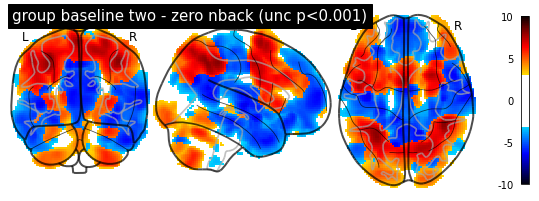

In [12]:
z_map_baseline = second_level_model_baseline.compute_contrast(output_type='z_score')
p_val = 0.001
p001_unc = norm.isf(p_val)
display = plotting.plot_glass_brain(
    z_map_baseline, threshold=p001_unc, colorbar=True, display_mode='ortho', plot_abs=False,
    title='group baseline two - zero nback (unc p<0.001)',vmax=10,vmin=-10)
plotting.show()

In [13]:
#one sample test for 1year
second_level_input_1year = cmaps_1year
design_matrix_1year = pd.DataFrame([1] * len(second_level_input_1year), columns=['two - zero'])
second_level_model_1year = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model_1year = second_level_model_1year.fit(second_level_input_1year,design_matrix=design_matrix_1year)

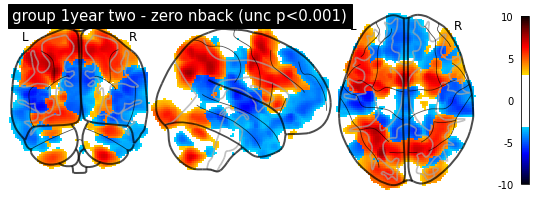

In [14]:
z_map_1year = second_level_model_1year.compute_contrast(output_type='z_score')
p_val = 0.001
p001_unc = norm.isf(p_val)
display = plotting.plot_glass_brain(
    z_map_1year, threshold=p001_unc, colorbar=True, display_mode='ortho', plot_abs=False,
    title='group 1year two - zero nback (unc p<0.001)',vmax=10,vmin=-10)
plotting.show()

In [15]:
#try out second level modeling...

n_subjects=len(cmaps_1year)

condition_effect = np.hstack(([1] * n_subjects, [- 1] * n_subjects))
#print(condition_effect)

subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = [f'S{i:02d}' for i in range(1, n_subjects + 1)]

#print(subjects)


paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=['baseline vs. 1year'] + subjects)

#display(paired_design_matrix)

unpaired_design_matrix = pd.DataFrame(
    condition_effect[:, np.newaxis],
    columns=['baseline vs. 1year'])

#display(unpaired_design_matrix)

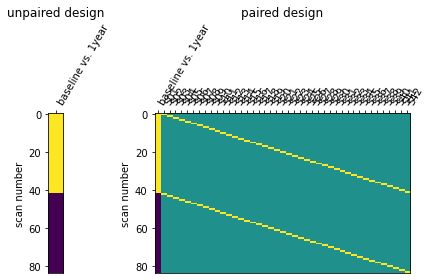

In [16]:
_, (ax_unpaired, ax_paired) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 17]})
plot_design_matrix(unpaired_design_matrix, rescale=False, ax=ax_unpaired)
plot_design_matrix(paired_design_matrix, rescale=False, ax=ax_paired)
ax_unpaired.set_title('unpaired design', fontsize=12)
ax_paired.set_title('paired design', fontsize=12)
plt.tight_layout()
plotting.show()

In [17]:
second_level_input = cmaps_baseline + cmaps_1year

In [18]:
second_level_model_unpaired = SecondLevelModel().fit(second_level_input, design_matrix=unpaired_design_matrix)
stat_maps_unpaired = second_level_model_unpaired.compute_contrast('baseline vs. 1year', output_type='all')

In [19]:
second_level_model_paired = SecondLevelModel().fit(second_level_input, design_matrix=paired_design_matrix)
stat_maps_paired = second_level_model_paired.compute_contrast('baseline vs. 1year', output_type='all')

In [20]:
(stat_maps_unpaired['effect_size'].get_fdata() - stat_maps_paired['effect_size'].get_fdata()).max()

0.0

In [21]:
# doesn't work for some reason...

# plotting.plot_glass_brain(stat_maps_unpaired['effect_variance'], colorbar=True, vmin=0, vmax=6, title='baseline vs. 1year effect variance, unpaired')

# plotting.plot_glass_brain(stat_maps_paired['effect_variance'], colorbar=True, vmin=0, vmax=6,title='baseline vs. 1year effect variance, paired')

# plotting.show()


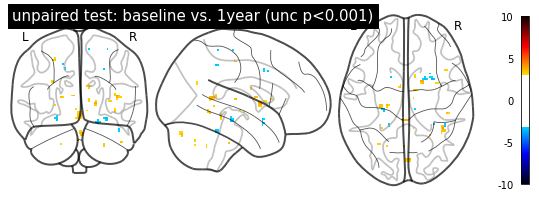

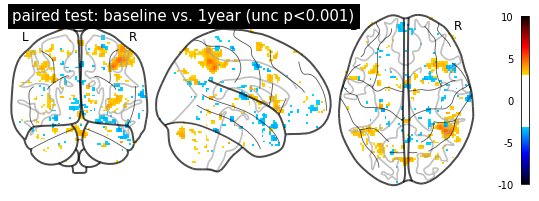

In [22]:
threshold = 3.1  # corresponds to  p < .001, uncorrected
display = plotting.plot_glass_brain(
    stat_maps_unpaired['z_score'], threshold=threshold, colorbar=True, plot_abs=False,
    title='unpaired test: baseline vs. 1year (unc p<0.001)', vmin=-10, vmax=10)

display = plotting.plot_glass_brain(
    stat_maps_paired['z_score'], threshold=threshold, colorbar=True, plot_abs=False,
    title='paired test: baseline vs. 1year (unc p<0.001)', vmin=-10, vmax=10)

plotting.show()

In [23]:
# task = 'nback'
# cmaps_baseline = glob.glob(f'../../derivatives/nilearn/first_level/sub-*_ses-baseline_task-{task}_rec-moco_effect_size.nii.gz')
# cmaps_1year = glob.glob(f'../../derivatives/nilearn/first_level/sub-*_ses-1year_task-{task}_rec-moco_effect_size.nii.gz')


In [24]:
cmaps_subtracted = []
for i in range(len(cmaps_baseline)):
    result_img = math_img("img1 - img2", img1=cmaps_baseline[i], img2=cmaps_1year[i])
    cmaps_subtracted.append(result_img)

In [25]:
#one sample test for baseline
second_level_input_subtracted = cmaps_subtracted
design_matrix_subtracted = pd.DataFrame([1] * len(second_level_input_subtracted), columns=['two - zero'])
second_level_model_subtracted = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model_subtracted = second_level_model_subtracted.fit(second_level_input_subtracted,design_matrix=design_matrix_subtracted)


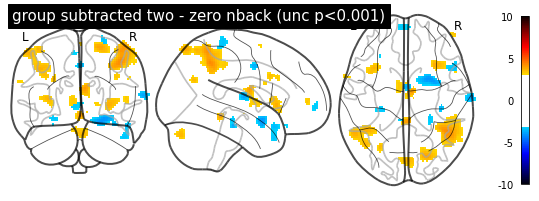

In [26]:
z_map_subtracted = second_level_model_subtracted.compute_contrast(output_type='z_score')
p_val = 0.001
p001_unc = norm.isf(p_val)
display = plotting.plot_glass_brain(
    z_map_subtracted, threshold=p001_unc, colorbar=True, display_mode='ortho', plot_abs=False,
    title='group subtracted two - zero nback (unc p<0.001)',vmax=10,vmin=-10)
plotting.show()

In [30]:
#without multiple comparisons correction, abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels

thresholded_map = threshold_img(
    stat_maps_paired,
    threshold=3.29,
    cluster_threshold=10,
    two_sided=True,
)

TypeError: threshold_img() got an unexpected keyword argument 'cluster_threshold'

In [31]:
#z-statistic image with a false positive rate < .001, cluster size > 10 voxels

thresholded_map1, threshold1 = threshold_stats_img(
    stat_maps_paired,
    alpha=.001,
    height_control='fpr',
    cluster_threshold=10,
    two_sided=True,
)

ValueError: File not found: 'z_score'

In [32]:
#FDR <.05 (False Discovery Rate) and no cluster-level threshold

thresholded_map2, threshold2 = threshold_stats_img(
    stat_maps_paired, alpha=.05, height_control='fdr')

print('The FDR=.05 threshold is %.3g' % threshold2)

ValueError: File not found: 'z_score'